**Bollinger Bands Trading Strategy Optimization, with specific Hang Sang Index Stocks </br>**

In [10]:
#@title Install and Import packages
#!pip install yfinance --upgrade
#!pip install talib-binary
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
#!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd ta-lib
#!./configure --prefix=/usr
#!make
#!make install
#!pip install Ta-Lib
#!pip install hkfdb

In [11]:
import os
import sys
import copy
from datetime import datetime, timedelta
import time
import itertools

import pandas as pd
import pandas_datareader as pdr
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import hkfdb
import yfinance as yf
import talib as ta
from talib import MA_Type

## **1) Defining Data Folder Structures & Parameters** 

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
#data folder structures
data_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data'
backtest_output_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/backtest_output'

**2) EDA with HKFDB**

In [13]:
#@title _hkfdb client
client = hkfdb.Database('94553819')

In [27]:
#retrieve all HK stock info, save to google drive
hkstock_db = client.get_basic_hk_stock_info()

# export to CSV file, retaining Chinese language and removing index
#hkstock_db.to_csv('hkstock_db.csv',encoding='utf-8-sig', index=False)

# use stored version of the hkfdb database
#path = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/hkstock_db.csv'
#hkstock_db = pd.read_csv(path, encoding='utf-8-sig')

hkstock_lotsize = hkstock_db[['code', 'lot_size']] 
hkstock_lotsize_dict = copy.deepcopy(hkstock_lotsize.set_index('code')['lot_size'].to_dict())

In [40]:
# Top 30 stocks by turnover
mid20_vol = hkstock_db.sort_values(by='turnover', ascending=False).iloc[10:30]
mid20_vol_list = top30_vol['code'].to_list()

In [41]:
# pair inverse trade stocks
ticker_list = mid20_vol_list

# define date range - yfinance format
start_date = '2021-03-20'
end_date = '2022-12-31'
interval = '1d'

# define date range - hkfdb format
start_date_hkfdb = 20210101
end_date_hkfdb = 20211231
interval_hkfdb = '1D'

# initial capital in HKD
initial_capital = 600000

# position sizing
pos_size = round(initial_capital/len(ticker_list),2)

**2) Getting OHLC Data from Yahoo Finance** </b>


*   Get stock data based on ticker list from Yahoo Finance
*   Create each stock data as different dataframe
*   Add Technical Analysis indicators from TA-Lib
*   Pointing working directory to data folder, export dach dataframe as independent csv file 





In [17]:
hkstock_lotsize = hkstock_db[['code', 'lot_size']] 
hkstock_lotsize_dict = hkstock_lotsize.set_index('code')['lot_size'].to_dict()

In [ ]:
# changing working directory to data folder's path
data_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data'
os.chdir(data_folder)

# getting OHLC data from yfinance package, if auto_adjust=True, OHLC data will not have adj close column, use progress=False to get rid of comments
# Other indicators: 14 day RSI
for ticker in ticker_list:
  try:

    #getting data from y-finance
    #hk_ticker = 'HK' + ticker[0:4]
    #globals()[hk_ticker] = pd.DataFrame
    #globals()[hk_ticker] = yf.download(ticker, start=start_date, end=end_date, interval=interval, auto_adjust=True, back_adjust=True, progress=False)
    
    #getting data from hkfdb
    hk_ticker = 'HK' + ticker[1:]
    globals()[hk_ticker] = pd.DataFrame
    globals()[hk_ticker] = client.get_hk_stock_ohlc(ticker, start_date_hkfdb, end_date_hkfdb, interval_hkfdb, price_adj=True, vol_adj=True)

    # clean-up import from hkfdb
    globals()[hk_ticker] = globals()[hk_ticker].drop(['date', 'time'], axis=1)
    globals()[hk_ticker] = globals()[hk_ticker].reset_index()
    globals()[hk_ticker].columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

    # adding technical indicators to the dataframe
    globals()[hk_ticker]['200EMA'] = ta.EMA(globals()[hk_ticker]['Close'], timeperiod=200) 
    globals()[hk_ticker]['ATR'] = ta.ATR(globals()[hk_ticker]['High'], globals()[hk_ticker]['Low'], globals()[hk_ticker]['Close'], timeperiod=14)
    globals()[hk_ticker]['RSI_14'] = ta.RSI(globals()[hk_ticker]['Close'], timeperiod=14)
    globals()[hk_ticker]['MACD'], globals()[hk_ticker]['MACD_signal'], globals()[hk_ticker]['MACD_hist'] = ta.MACD(globals()[hk_ticker]['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    globals()[hk_ticker]['ADX'] = ta.ADX(globals()[hk_ticker]['High'], globals()[hk_ticker]['Open'], globals()[hk_ticker]['Close'], 14)
    globals()[hk_ticker]['MFI'] = ta.MFI(globals()[hk_ticker]['High'], globals()[hk_ticker]['Low'], globals()[hk_ticker]['Close'], globals()[hk_ticker]['Volume'], 14)
    globals()[hk_ticker]['WILL%R'] = ta.WILLR(globals()[hk_ticker]['High'], globals()[hk_ticker]['Low'], globals()[hk_ticker]['Close'], timeperiod=14)
    globals()[hk_ticker]['BBand_U'], globals()[hk_ticker]['BBand_M'], globals()[hk_ticker]['BBand_L'] = ta.BBANDS(globals()[hk_ticker]['Close']) # if add exponential smoothing, matype=MA_Type.T3

    # add/drop columns and clean up - yfinance/ generic
    globals()[hk_ticker] = globals()[hk_ticker].dropna()
    #globals()[hk_ticker] = globals()[hk_ticker].reset_index()
    globals()[hk_ticker][['Position', 'Win Count']] = 0
    globals()[hk_ticker][['Lot Size', 'Equity Value', 'MDD_dollar', 'PNL', 'Holding Period']] = np.NAN
    
    #writing each ticker dataframe into separate .csv files, save to google drive
    #globals()[ticker].to_csv(ticker+'.csv', index=False, header=True)
  except:
    print(globals()[ticker])

**Other Optional Indicators:** </b>

**MACD_hist** - globals()[ticker]['MACD'], globals()[ticker]['MACD_signal'], globals()[ticker]['MACD_hist'] = ta.MACD(globals()[ticker]['Close'], fastperiod=12, slowperiod=26, signalperiod=9) </b>

**ADX** - globals()[ticker]['ADX'] = ta.ADX(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14) </b>


**ADXR** - globals()[ticker]['ADXR'] = ta.ADXR(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14) </b>

**50 Day Exponential Moving Average** - globals()[ticker]['50EMA'] = ta.EMA(globals()[ticker]['Close'], timeperiod=50) </b>

**Bollinger Bands** - globals()[ticker]['BBand_U'], globals()[ticker]['BBand_M'], globals()[ticker]['BBand_L'] = ta.BBANDS(globals()[ticker]['Close']) # if add exponential smoothing, matype=MA_Type.T3

**Stochastic Indicators** - globals()[ticker]['Stoch_slowk'], globals()[ticker]['Stoch_slowd'] = ta.STOCH(globals()[ticker]['High'], globals()[ticker]['Low'], globals()[ticker]['Close'],                                                              fastk_period=21, slowk_period=5, slowk_matype=0, slowd_period=5, slowd_matype=0)    

**3) Building the DataFrame List, Perform Backtesting**

In [36]:
#manipulate ticker list
new_ticker_list = []
for ticker in ticker_list:
  new_ticker = 'HK' + ticker[1:]
  new_ticker_list.append(new_ticker)

In [46]:
new_ticker_list

['HK0700',
 'HK3690',
 'HK9988',
 'HK2800',
 'HK2828',
 'HK2318',
 'HK2269',
 'HK1299',
 'HK1024',
 'HK0939',
 'HK3968',
 'HK0941',
 'HK9618',
 'HK0388',
 'HK1211',
 'HK1877',
 'HK2628',
 'HK1398',
 'HK2015',
 'HK9999',
 'HK3033',
 'HK1928',
 'HK3988',
 'HK0175',
 'HK1093',
 'HK2331',
 'HK0883',
 'HK1810',
 'HK1177',
 'HK6098']

In [47]:
# list of dataframes to be iterated after yfinance data pull 
df_list = [HK0700, HK3690, HK9988, HK2800, HK2828, HK2318, HK2269, HK1299, HK1024, HK0939, HK3968, HK0941, HK9618, HK0388, HK1211, HK1877, HK2628, HK1398, HK2015, HK9999, HK3033, HK1928, HK3988, HK0175, HK1093, HK2331, HK0883, HK1810, HK1177]

In [48]:
# function to extract dataframe name
def get_df_name(df):
   name =[x for x in globals() if globals()[x] is df][0]
   return name

In [49]:
# function to print function name as a string
def get_func_name(func_name):
    func_name = sys._getframe().f_code.co_name
    return func_name

**MACD Bollinger Bands Strategy**

*   Entry Rule: Open Price < Lower Bollinger Band, MACD > MACD signal line > 0
*   Exit Rule: Hit profit target/ stop loss/ last day of trade, MACD < signal line



In [50]:
# defining the global list for storing trade list output
global bb_macd_tradelist
bb_macd_tradelist = []

pos_size = round(initial_capital/len(ticker_list),2)

In [61]:
# defining a backtest function based on trading rules, capture all transactions

def backtest_bbmacd(df):
  df_name = get_df_name(df)

  pos_opened = False
  open_price  = 0
  close_price = 0
  lot_size = 0

  initial_equity_value = 0
  win_counter = 0
  open_trade_date = 0
  holding_days = 0

  pnl = 0
  pnl_list = []
    
  for i in range(len(df)):
    now_date        = df.loc[i, 'Date']
    now_open        = df.loc[i, 'Open']
    now_close       = df.loc[i, 'Close']
    now_200EMA      = df.loc[i, '200EMA']
    now_rsi_14      = df.loc[i, 'RSI_14']
    now_MACD        = df.loc[i, 'MACD']
    now_MACD_signal = df.loc[i, 'MACD_signal']
    now_MACD_hist   = df.loc[i, 'MACD_hist']
    now_bband_u     = df.loc[i, 'BBand_U']
    now_bband_m     = df.loc[i, 'BBand_M']
    now_bband_l     = df.loc[i, 'BBand_L']
    now_position    = df.loc[i, 'Position']
    now_equity_val  = df.loc[i, 'Equity Value']
    now_mdd_dollar  = df.loc[i, 'MDD_dollar']
    now_win_count   = df.loc[i, 'Win Count']

    # opening a position
    if (pos_opened == False and (now_open < now_bband_l and now_MACD > now_MACD_signal and now_MACD_hist > 0)):
      pos_opened = True
      open_trade_date = now_date
      open_price = now_open
      lot_size = pos_size// open_price
      buy_commission = (0.0049 + 0.005) * lot_size
      initial_equity_value = round(((lot_size * open_price) - buy_commission),2)
      df.at[i, 'Position'] = 1
      df.at[i, 'Lot Size'] = lot_size
      df.at[i, 'Equity Value'] = initial_equity_value
      bb_macd_tradelist.append([now_date, df_name, pos_opened, open_price, lot_size, initial_equity_value])

    # closing a position - by MACD signal, or last day of trading or hit stop loss
    elif (pos_opened == True and ((now_MACD < now_MACD_signal) or \
                                  (lot_size * now_open > initial_equity_value * 1.2) or (lot_size * now_open < initial_equity_value * 0.95) or \
                                  (now_date == df.loc[(len(df)-1), 'Date']))):
      pos_opened = False
      close_price = now_open
      sell_commission = (0.04 * lot_size) + (close_price * lot_size * 0.0000229)
      df.at[i, 'Position'] = 2
      df.at[i, 'Lot Size'] = lot_size
      df.at[i, 'Equity Value'] = (close_price * lot_size)
      if (now_open * lot_size) < initial_equity_value:
        df.loc[i, 'MDD_dollar']   = -(initial_equity_value - (now_open * lot_size))
      else:
        df.loc[i, 'MDD_dollar']   = 0
      holding_days = now_date - open_trade_date
      df.at[i, 'Holding Period'] = holding_days.days
      
      pnl = round(((close_price * lot_size) - sell_commission) - initial_equity_value,2)
      df.at[i, 'PNL'] = pnl.round(2)
      if pnl > 0:
        df.at[i, 'Win Count'] = 1
        win_counter += 1
      pnl_list.append(pnl)
      bb_macd_tradelist.append([now_date, df_name, pos_opened, close_price, lot_size, (close_price*lot_size), pnl, holding_days])

      # reset values
      open_price = 0
      close_price = 0
      initial_equity_value = 0
      lot_size = 0
      open_trade_date = 0

    else:
      df.loc[i, 'Equity Value']   = (now_open * lot_size)
      df.loc[i, 'Lot Size']       = lot_size
      if (now_open * lot_size) < initial_equity_value:
        df.loc[i, 'MDD_dollar']   = initial_equity_value - (now_open * lot_size)
      else:
        df.loc[i, 'MDD_dollar']   = 0

  total_profit = round(sum(pnl_list), 2)
  num_of_trade = round(len(pnl_list), 2)
  avg_pnl = round(total_profit/ num_of_trade, 2) if num_of_trade else 0
  max_mdd = df['MDD_dollar'].min().round(2)
  avg_hold_period = df['Holding Period'].mean().round(2)
  win_rate = round(win_counter/ num_of_trade * 100,2)

  return df_name, num_of_trade, total_profit, avg_pnl, max_mdd, avg_hold_period, win_rate

In [62]:
# create a for loop, put together trade summary list
bbmacd_result_list = []

for df in df_list:
  try:
    df_name = get_df_name(df)
    test_result = backtest_bbmacd(df)
    bbmacd_result_list.append(test_result)

    bbmacd_result_df = pd.DataFrame(bbmacd_result_list)
    bbmacd_result_df.columns = ['Ticker', 'No of Trade', 'Total PNL', 'Avg PNL/ Trade', 'Maximum Drawdown', 'Avg Holding Days', 'Win Rate %']
  except: 
    test_result_null = bbmacd_result_list.append([df_name, 0, 0, 0, 0, 0, 0])
    bbmacd_result_df = pd.DataFrame(bbmacd_result_list)
    bbmacd_result_df.columns = ['Ticker', 'No of Trade', 'Total PNL', 'Avg PNL/ Trade', 'Maximum Drawdown', 'Avg Holding Days', 'Win Rate %']

In [63]:
# PNL for Bollinger Bands + MACD Strategy

#measure_date = df_list[1].loc[1, 'Date']
#end_date = df_list[1].loc[df.index[-1], 'Date'] 
print('Trading Strategy: Bollinger Bands + MACD')
#print('Trade period:', (measure_date.strftime('%Y-%m-%d')), 'to', end_date.strftime('%Y-%m-%d'))
ROI = ((bbmacd_result_df['Total PNL'].sum()/ initial_capital)*100).round(2)
MDD = bbmacd_result_df['Maximum Drawdown'].mean().round(2)
print('Total No of Trades Executed:', (bbmacd_result_df['No of Trade'].sum()))
print('Total PNL: HKD', bbmacd_result_df['Total PNL'].sum().round(2))
print('Capital Deployed: USD', initial_capital)
print('ROI: ', ROI, '%')
print('Avg Win Rate: ', round(bbmacd_result_df[bbmacd_result_df['No of Trade'] > 0]['Win Rate %'].mean(),2), '%')
bbmacd_result_df[bbmacd_result_df['No of Trade'] > 0].sort_values(by=['Total PNL', 'Avg PNL/ Trade'], ascending=False)


Trading Strategy: Bollinger Bands + MACD
Total No of Trades Executed: 0
Total PNL: HKD 0
Capital Deployed: USD 600000
ROI:  0.0 %
Avg Win Rate:  nan %


,Ticker,No of Trade,Total PNL,Avg PNL/ Trade,Maximum Drawdown,Avg Holding Days,Win Rate %


**4) Other EDA Indicators**

In [56]:
# Extracting only close price from various dataframes
start = df_list[0].loc[1, 'Date']
end = df_list[0].loc[df.index[-1], 'Date'] 

df_close_price = []
df_close_price.append(df_list[0]['Date'].to_list())
bench_list = ['DX-Y.NYB', '^TNX']

for close_price in df_list:
  price = close_price['Close'].to_list()
  df_close_price.append(price)

for ticker in bench_list:
  bench_close = yf.download(ticker, start=start, end=end, interval=interval, auto_adjust=True, back_adjust=True, progress=False)['Close']
  df_close_price.append(bench_close)

# putting everything to a dataframe, adding the column headers
all_df = pd.DataFrame(df_close_price).T
#all_df.columns = ['Date', 'TQQQ', 'SQQQ', 'SPXL', 'SPXS', 'TZA', 'TNA', 'SOXL', 'SOXS', 'FAS', 'FAZ', 'LABD', 'LABU', 'EDZ', 'EDC', 'USD Index', '10-yr T.Note']

# changing dataframe from object to numeric for plotting heatmap
for col in all_df.columns[1:]:
    all_df[col] = pd.to_numeric(all_df[col], errors='coerce')


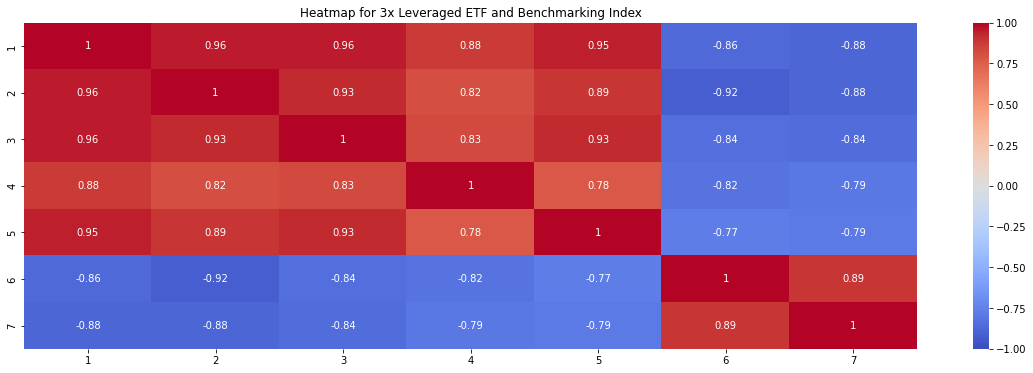

In [57]:
plt.figure(figsize=(20,6))
plt.title('Heatmap for 3x Leveraged ETF and Benchmarking Index')
#mask = np.triu(np.ones_like(all_df.corr())) #--> add syntax mask=mask to produce diagonal heatmap
sns.heatmap(all_df.corr(), annot = True, vmin=-1, vmax=1, center=0, cmap='coolwarm') #--> mask=mask to create diagonal heatmap

Downloading the Full Transaction List


In [60]:
full_trade = pd.DataFrame(bb_macd_tradelist)
full_trade.columns = ['Transaction Date', 'Ticker', 'Trade Opened', 'Unit Price', 'Lot Size', 'Equity Value', 'PNL', 'Holding Period']

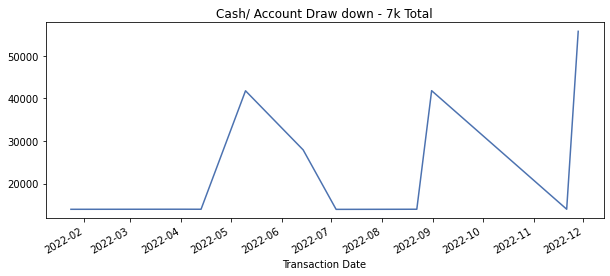

In [61]:
cash_consumed = full_trade[full_trade['Trade Opened'] == True].groupby('Transaction Date')['Equity Value'].agg('sum')
cash_consumed.plot(figsize=(10,4), title='Cash/ Account Draw down - 7k Total')

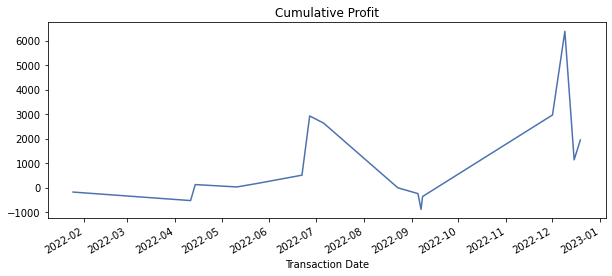

In [62]:
cum_profit = full_trade[full_trade['Trade Opened'] == False].groupby('Transaction Date')['PNL'].agg('sum')
cum_profit.plot(figsize=(10,4), title='Cumulative Profit')

In [63]:
# export to csv
full_trade.to_csv('full_tradeHK2022.csv')